In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from pybasicbayes.distributions import Gaussian
from sklearn.cluster import KMeans
import hsmmsgd_metaobs as HSMMSGD


/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


In [8]:
centers = np.array([np.array([0,0]),np.array([4,4]),np.array([0,6]),np.array([8,6])])


K = 4           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 1.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0 ,0.3,0.6,0.1],
    [0.2, 0 ,0.7,0.1],
    [0.7,0.2, 0 ,0.1],
    [0.7,0.2,0.1, 0 ]
    ])

N = 1000
lambda_js = np.arange(1,K+1)*2 + 2


from generate_data import *
emit = make_emissions(centers , kappa_0, nu_0)

seq_hsmm, ind = generate_states_pois(T,lambda_js,N)

obs_hsmm = generate_data(emit,ind)

kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)

np.savetxt("data.csv", obs_hsmm, delimiter=",")


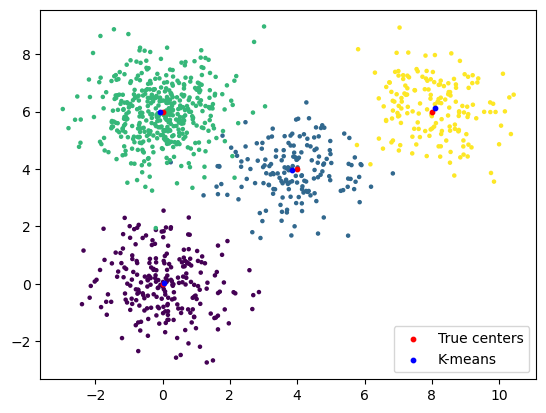

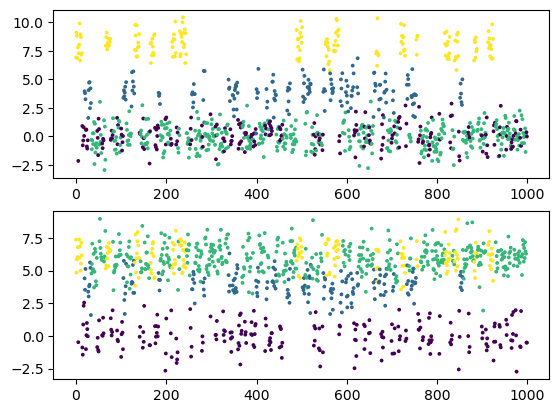

In [9]:
plt.scatter(obs_hsmm[:,0],obs_hsmm[:,1],  s=5, c =seq_hsmm)
plt.scatter(centers[:,0],centers[:,1], s=10, c='red',label = 'True centers')
plt.scatter(mu_0[:,0],mu_0[:,1], s=10, c='blue', label = 'K-means')
plt.legend()
plt.show()
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm )
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm )

In [10]:
kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs_hsmm.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emissions for each super state
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_A = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
np.fill_diagonal(prior_A, 0)

prior_pi0 = np.ones(K)                     # ?
# -----------------------------------------------------------------
m_js,lambda_js = np.ones(K,dtype='int')*10, np.array(lambda_js,dtype='int')



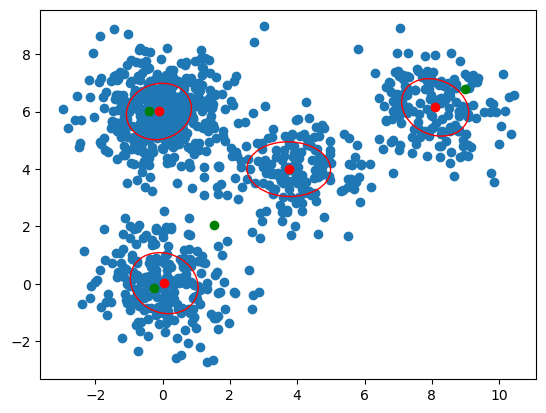

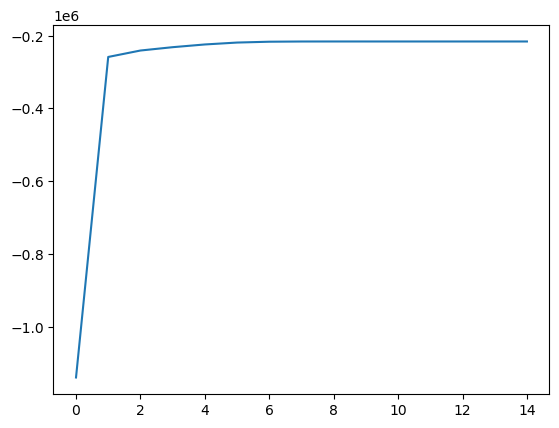

time is:  2.7767651081085205


In [11]:
import hsmmbatchcd as HSMM
import util
from scipy.stats import invwishart,t,beta
import time 
# define object for inferrence from hmmbatchcd.py
# # pass priors on init transitions and emissions for each state
hsmm = HSMM.VBHSMM(obs_hsmm, prior_pi0, prior_A, prior_emit,m_js,lambda_js,maxit=15, epsilon=10**(-10))  
start_time = time.time()
hsmm.infer() # do inference 
end_time = time.time()
sts_true = seq_hsmm # true states 
# hamming distance
##print(prior_emit[0].mu_mf)
##print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs_hsmm, prior_emit, hsmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hsmm.elbo_vec)
plt.show()
elapsed_time_VB = end_time - start_time 
print('time is: ',elapsed_time_VB)

In [12]:
import stan
import numpy as np
import nest_asyncio
import time
nest_asyncio.apply()
mu_0_ = KMeans(init="random",n_clusters=1,n_init=10,max_iter=300,random_state=42).fit(obs_hsmm).cluster_centers_[0]
dat = [tuple(i) for  i in obs_hsmm]
data = {'y':dat , "N": N, "D":D, "K":K,'m':m_js, 'mu_0':mu_0_ , 'kappa_0':kappa_0/K, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,K-1)),'lambda':lambda_js} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_approxHSMM_PoisDur_lambdaFixed.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
start_time = time.time()
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 700 )
end_time = time.time()

elapsed_time_MCMC = end_time - start_time 

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 41, column 33: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 45, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_upt2n2te/model_7nymjnd5.stan', line 70, column 25: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan

Hamming Distance =  0.156


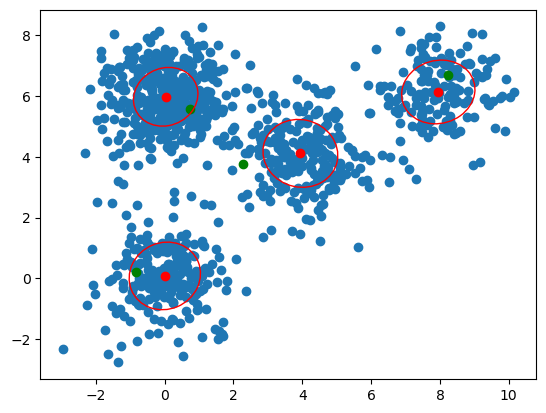

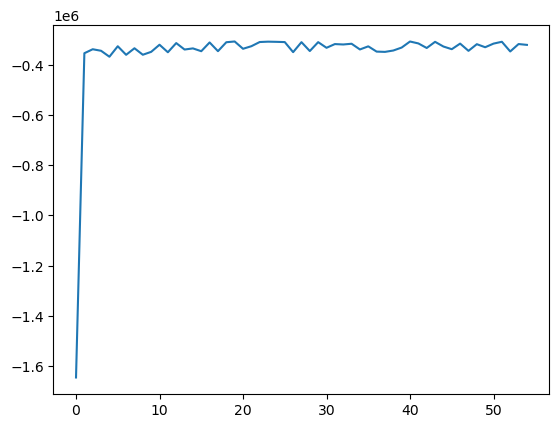

8.457005023956299


In [ ]:
maxit = 55
metaobs_half = 400
mb_sz = 1

hsmm_sgd = HSMMSGD.VBHSMM(obs_hsmm, prior_pi0, prior_A, prior_emit,m_js,lambda_js,maxit=maxit,metaobs_half=metaobs_half, mb_sz=mb_sz)  

start_time = time.time()
hsmm_sgd.infer()
end_time = time.time()
full_var_x = hsmm_sgd.full_local_update()

print('Hamming Distance = ', hsmm_sgd.hamming_dist(full_var_x, seq_hsmm)[0])

# plot learned emissions over observations
util.plot_emissions(obs_hsmm, prior_emit, hsmm_sgd.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hsmm_sgd.elbo_vec)
plt.show()

elapsed_time_sgd = end_time - start_time
print(elapsed_time_sgd)


In [ ]:
def rshp(arr):
    return arr.reshape(arr.shape[0], -1)

np.savetxt("fit_mu.csv", rshp(fit['mu']), delimiter=",")
np.savetxt("fit_Sigma.csv", rshp(fit['Sigma']), delimiter=",")
np.savetxt("fit_gamma.csv", rshp(fit['gamma']), delimiter=",")
# load_original_arr = loaded_arr.reshape(
#     loaded_arr.shape[0], loaded_arr.shape[1] // arr.shape[2], arr.shape[2])

In [ ]:
from scipy.stats import invwishart,t,beta
import seaborn as sns

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        if i == j :
            pass
        elif i < j:
            MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j-1]
        else:
            MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]
        
VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hsmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]

for i in range(0,len(hsmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hsmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hsmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hsmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hsmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hsmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hsmm.var_A[i][j]

SVI_mus = {}
SVI_sig = {}
SVI_kapp = {}
SVI_nu = {}
SVI_alphas = {}

true_map_SVI = [np.argmin(np.sqrt(np.sum((hsmm_sgd.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]

for i in range(0,len(hsmm_sgd.var_emit)):
    SVI_mus[str(true_map_SVI[i])] = hsmm_sgd.var_emit[i].mu_mf
    SVI_sig[str(true_map_SVI[i])] = hsmm_sgd.var_emit[i].sigma_mf
    SVI_kapp[str(true_map_SVI[i])] = hsmm_sgd.var_emit[i].kappa_mf
    SVI_nu[str(true_map_SVI[i])] = hsmm_sgd.var_emit[i].nu_mf
    SVI_alphas[str(true_map_SVI[i])] = {}
    for j in range(0,len(hsmm_sgd.var_emit)):
        SVI_alphas[str(true_map_SVI[i])][str(true_map_SVI[j])] = hsmm_sgd.var_A[i][j]

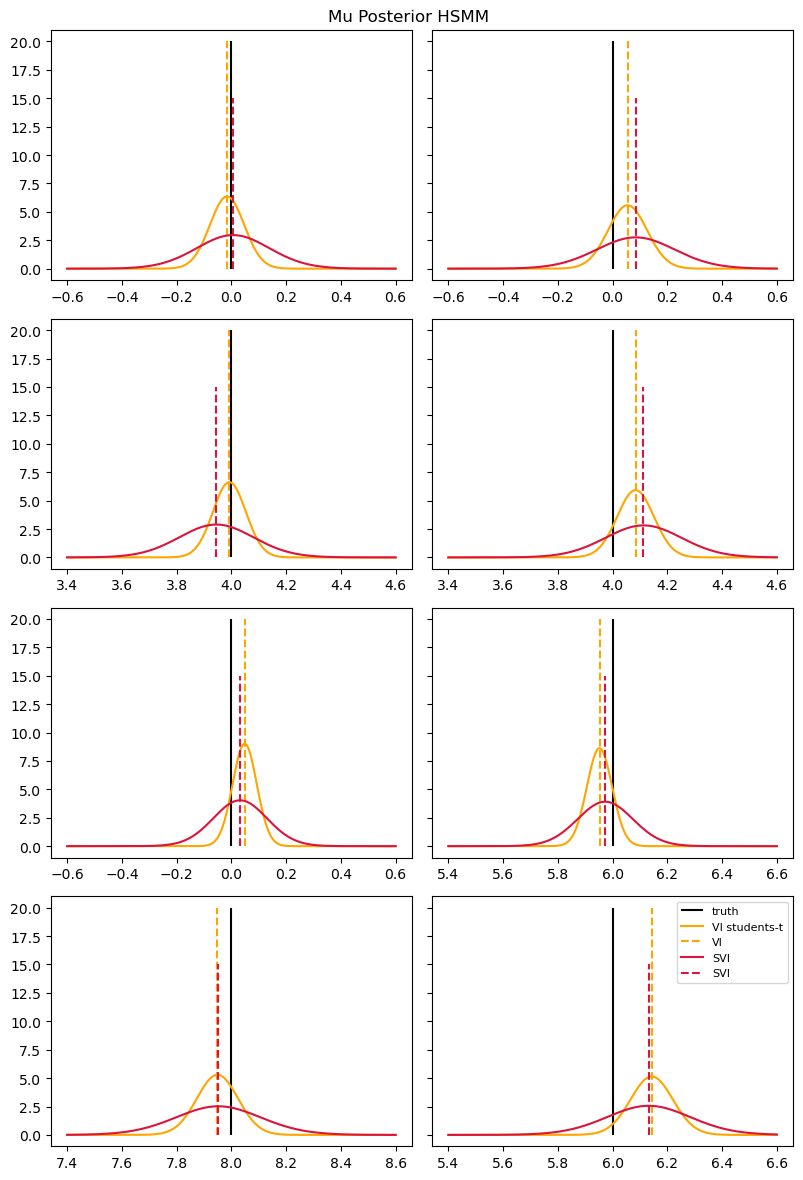

In [ ]:
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0,20,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')
        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')
# VI
        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI students-t',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')
# SVI
        scale_kd = np.diag(SVI_sig[str(k+1)])[d] / (SVI_kapp[str(k+1)]*( SVI_nu[str(k+1)] + D - 1 ))
        
        dist2 = t.pdf(x, df = SVI_nu[str(k+1)], loc=SVI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))

        ax.plot(x, dist2,label = 'SVI',color = 'crimson')

        ax.vlines(SVI_mus[str(k+1)][d],0,15,color = 'crimson',label='SVI',linestyles='dashed')

        # plt.ylim((0,20))
plt.suptitle('Mu Posterior HSMM')
plt.legend(fontsize = 8)
plt.tight_layout()


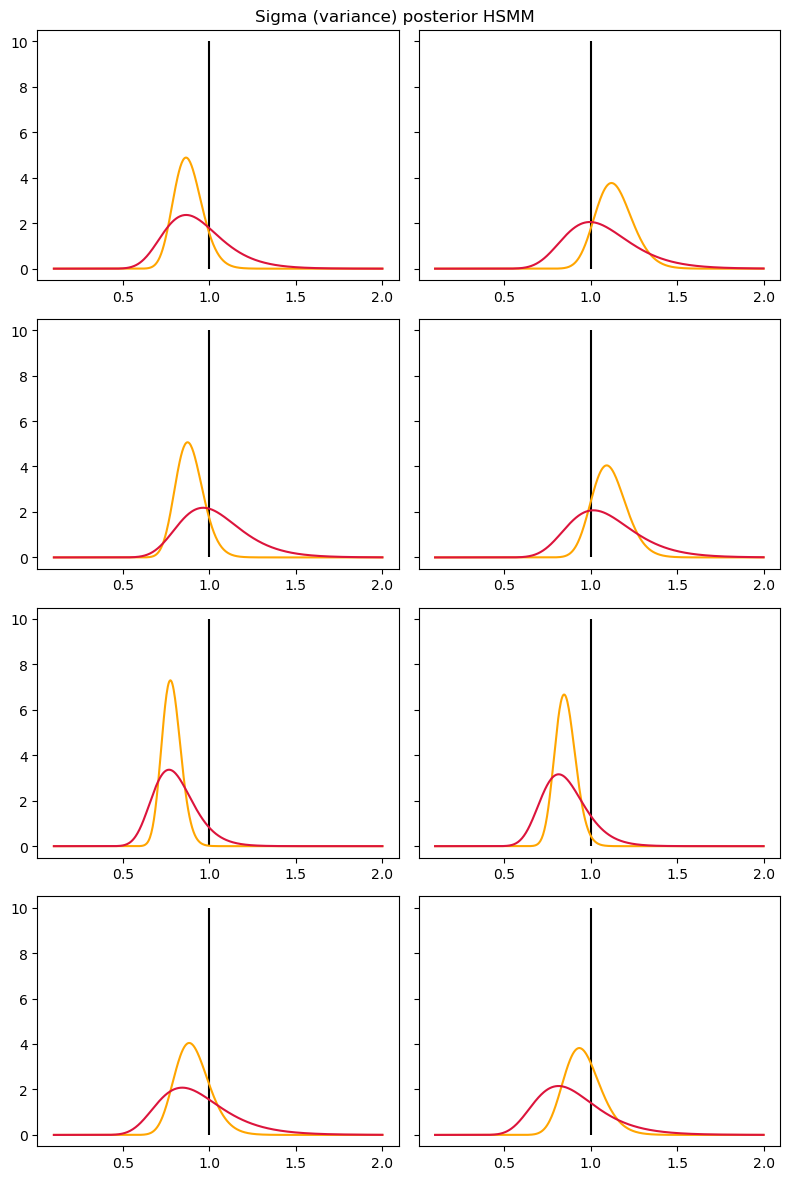

In [ ]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')
        
        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI',color = 'orange')
        
        iw = invwishart.pdf(x, df=SVI_kapp[str(k+1)], scale = np.diag(SVI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'SVI',color = 'crimson')
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigma (variance) posterior HSMM')
# plt.legend(fontsize = 8)
plt.tight_layout()

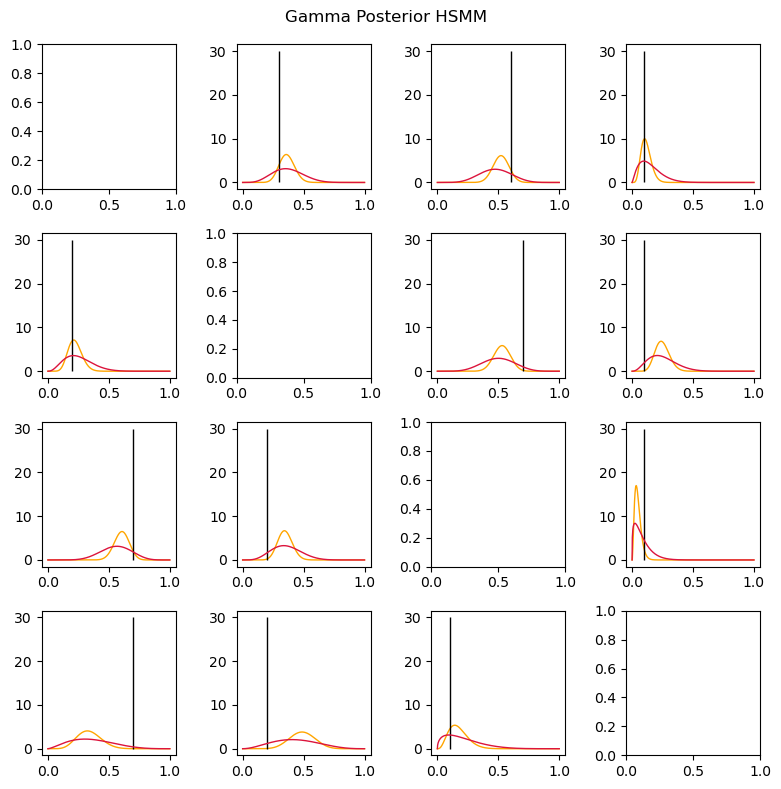

In [ ]:
K=4
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        if k==j:
            pass

        else:
            ax = axs[k,j]
            sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0, color = 'royalblue')
            x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)
            x = np.linspace(0,1,500)
            dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist,label = 'VI',color = 'orange',linewidth=1.0)
            ax.vlines(T[k][j],0,30,color = 'black',label='truth',linewidth=1.0)
            #SVI
            dist2 = beta.pdf(x,SVI_alphas[str(k+1)][str(j+1)] , sum(SVI_alphas[str(k+1)].values())-SVI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist2,label = 'SVI beta',color = 'crimson',linewidth=1.0)

            # ax.set_xlim(0,1)
            ax.set(ylabel=None)
        # if k==(K-1):
        #     if j==(K-2):
        #         ax.legend(['VI', 'truth'], fontsize=8)



plt.suptitle('Gamma Posterior HSMM')
plt.tight_layout()
plt.show()